
# Download PyTorch

PyTorch does not come with CoLab so every time we restart this notebook we have to redownload it.


In [0]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
!pip install -q torch==1.0.0 torchvision

    100% |████████████████████████████████| 591.8MB 27kB/s 
    100% |████████████████████████████████| 2.0MB 6.5MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
!pip install pytorch-nlp

    100% |████████████████████████████████| 92kB 7.3MB/s 


# Wikipedia data for LM pretraining

Our dad jokes dataset does not have that many samples so its performance is not great as-is. The major problem with having so few examples is that the model needs to learn both how to make jokes and how to compose words, and this is too much to ask of a small dataset. To learn how words are made, we are downloading a corpus based on Wikipedia to pretrain our model. We are going to use the WikiText-2 corpus that Salesforce has shared (I wanted to use WikiText-103 but CoLab doesnt give enough RAM)

In [0]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip

--2019-03-04 17:43:54--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.101.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.101.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4721645 (4.5M) [application/zip]
Saving to: ‘wikitext-2-raw-v1.zip’

wikitext-2-raw-v1.z 100%[===================>]   4.50M  6.87MB/s    in 0.7s    

2019-03-04 17:43:55 (6.87 MB/s) - ‘wikitext-2-raw-v1.zip’ saved [4721645/4721645]



In [0]:
!unzip wikitext-2-raw-v1.zip

Archive:  wikitext-2-raw-v1.zip
   creating: wikitext-2-raw/
  inflating: wikitext-2-raw/wiki.test.raw  
  inflating: wikitext-2-raw/wiki.valid.raw  
  inflating: wikitext-2-raw/wiki.train.raw  


In [0]:
!ls -lh wikitext-2-raw

total 13M
-rw-rw---- 1 root root 1.3M Aug 15  2016 wiki.test.raw
-rw-rw---- 1 root root  11M Aug 15  2016 wiki.train.raw
-rw-rw---- 1 root root 1.1M Aug 15  2016 wiki.valid.raw


# Define classes

In [0]:
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import multiprocessing as mp
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import *
from typing import List, Tuple
import os
import csv
import time

In [0]:
from torchnlp.samplers import BucketBatchSampler
from torchnlp.datasets import snli_dataset
from torchnlp.utils import datasets_iterator
from torchnlp import word_to_vector

In [0]:
import sys
import tqdm as tq
from tqdm import tqdm_notebook, tnrange


def in_ipynb():
    try:
        cls = get_ipython().__class__.__name__
        return cls == 'ZMQInteractiveShell'
    except NameError:
        return False


def in_notebook():
    try:
        from ipykernel.kernelapp import IPKernelApp
        return IPKernelApp.initialized()
    except ImportError:
        return False


def clear_tqdm():
    inst = getattr(tq.tqdm, '_instances', None)
    if not inst: return
    try:
        for i in range(len(inst)): inst.pop().close()
    except Exception:
        pass

if in_notebook():
    def tqdm(*args, **kwargs):
        clear_tqdm()
        return tq.tqdm(*args, file=sys.stdout, **kwargs)
    def trange(*args, **kwargs):
        clear_tqdm()
        return tq.trange(*args, file=sys.stdout, **kwargs)
else:
    from tqdm import tqdm, trange
    tnrange=trange
    tqdm_notebook=tqdm

In [0]:
from typing import List, Union
from collections import deque

class CharByteEncoder():
  def __init__(self):
    self.start_token = '<s>'
    self.end_token = '</s>'
    self.pad_token = '<pad>'
    
    self.start_idx = 256
    self.end_idx = 257
    self.pad_idx = 258
    
  def encode(self, s: str, pad_to=0) -> torch.LongTensor:
    encoded = s.encode()
    n_pad = pad_to - len(encoded) if pad_to > len(encoded) else 0
    return torch.LongTensor([self.start_idx] + 
            [c for c in encoded] + 
            [self.end_idx] + 
            [self.pad_idx for _ in range(n_pad)]
    )
  
  def decode(self, char_ids_tensor: torch.LongTensor) -> str:
    """
    Decodes a list of char IDs. The structure can be like this:
    <s>[body]</s><pad>* so we check for that.
    """
    char_ids = char_ids_tensor.cpu().detach().tolist()
    
    out = []
    buf = []
    for c in char_ids:
      if c < 256:
        buf.append(c)
      else:
        if buf:
          out.append(bytes(buf).decode())
          buf = []
        if c == self.start_idx:
          out.append(self.start_token)
        elif c == self.end_idx:
          out.append(self.end_token)
        elif c == self.pad_idx:
          out.append(self.pad_token)
      
    if buf:  # in case some are left
      out.append(bytes(buf).decode())
    return ''.join(out)

  def __len__(self):
    return 259 # 256 combinations in a byte, plus 3 special chars

In [0]:
import os
os.getcwd()

'/content'

In [0]:
WIKIPEDIA_DATA_PATH = "wikitext-2-raw/wiki.train.raw"

PyTorch wants us to define a Dataset class that will be used during training. We are training our language model by having multiple sequences each batch. Each sentence needs to stay together for the LSTM to learn the sequential relationship. We are therefore making each sample a sentence, with the target being the next character. So if the input is `"<s>hello!</s>"` then we are going to have this: `{text: '<s>hello', next: 'hello</s>'}`.

In [0]:
from torch.utils.data import Dataset

class WikiDataset(Dataset):
    def __init__(self, path, char_budget=70):
        with open(path, 'r') as fin:
          self.data = [line.strip() for line in fin.readlines()]
        print(f"Dataset made of {len(self.data)} rows")
        self.char_budget = char_budget
        self.text_encoder = CharByteEncoder()
        self.samples = []
        for _i in tqdm(range(len(self.data)), total=len(self.data)):
            sentence = self.data.pop()
            if sentence.startswith('='):
              del sentence
              continue
            encoded_samples = self.generate_language_model_samples(sentence, 
                                                                   self.char_budget)
            self.samples.extend(
                (e for e in encoded_samples 
                 if len(e['text']) < 4 * self.char_budget)
            )
            del sentence
        del self.data
    
    def get_single_sample(self, s):
        """
        Input: 'my funny joke'
        Output: {
          text: '<s>my funny joke'
          next: 'my funny joke</s>'
        }
        """
        encoded = self.text_encoder.encode(s)
        return {'text': encoded[:-1], 'next': encoded[1:]}
        
    def generate_language_model_samples(self, sentence, char_budget_per_row):
        """
        Input: "My very funny super long string, containing lots of words"
        Output:
        [
          {
            text: '<s>My very funny super'
            next: 'My very funny super</s>'
          },
          {
            text: '<s>long string, containing'
            next: 'long string, containing </s>'
          },
          {
            text: '<s>lots of words'
            next: 'lots of words</s>'
          },
        ]
        """
        
        return [
            self.get_single_sample(s) 
            for s in self.split_long_strings(sentence.split(), char_budget_per_row)
        ]
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def getitem_readable(self, i):
        return {'text': self.text_encoder.decode(self.samples[i]['text']),
               'next': self.text_encoder.decode(self.samples[i]['next'])}
      
    def split_long_strings(self, words: List[str], char_budget:int):
        """
        Given a list of words, take words until you go over your char_budget.
        This allows us to set a max size in chars without breaking up words.
        If your char_budget is 1000, you should expect to hover around that
        limit: maybe some sequences will be of size 1020, others of size 1007...
        """
        cur = []
        taken = 0
        for i, word in enumerate(words):
            cur.append(word)
            taken += len(word)
            if taken > char_budget or i == len(words)-1:
              yield " ".join(cur)
              cur = []
              taken = 0

    

In [0]:
wiki_dataset = WikiDataset(WIKIPEDIA_DATA_PATH)

Dataset made of 36718 rows
100%|██████████| 36718/36718 [00:06<00:00, 5962.45it/s]


In [0]:
len(wiki_dataset)

127375

In [0]:
for i in range(10):
  print(wiki_dataset.getitem_readable(i))

{'text': '<s>Common starlings are trapped for food in some Mediterranean countries . The meat is tough', 'next': 'Common starlings are trapped for food in some Mediterranean countries . The meat is tough</s>'}
{'text': '<s>and of low quality , so it is casseroled or made into pâté . One recipe said it should be stewed', 'next': 'and of low quality , so it is casseroled or made into pâté . One recipe said it should be stewed</s>'}
{'text': '<s>" until tender , however long that may be " . Even when correctly prepared , it may still', 'next': '" until tender , however long that may be " . Even when correctly prepared , it may still</s>'}
{'text': '<s>be seen as an acquired taste .', 'next': 'be seen as an acquired taste .</s>'}
{'text': '<s>Mozart had a pet common starling which could sing part of his Piano Concerto in G Major', 'next': 'Mozart had a pet common starling which could sing part of his Piano Concerto in G Major</s>'}
{'text': '<s>( KV . 453 ) . He had bought it from a shop a

In [0]:
wiki_dataset.samples[18]

{'next': tensor([119, 104, 111, 108, 101,  32, 115, 101, 110, 116, 101, 110,  99, 101,
         115,  32, 105, 110,  32,  76,  97, 116, 105, 110,  32,  97, 110, 100,
          32,  71, 114, 101, 101, 107,  32,  44,  32,  97, 110, 100,  32, 105,
         110,  32,  72, 101, 110, 114, 121,  32,  73,  86,  32,  44,  32,  87,
         105, 108, 108, 105,  97, 109,  32,  83, 104,  97, 107, 101, 115, 112,
         101,  97, 114, 101,  32, 104,  97, 100,  32,  72, 111, 116, 115, 112,
         117, 114, 257]),
 'text': tensor([256, 119, 104, 111, 108, 101,  32, 115, 101, 110, 116, 101, 110,  99,
         101, 115,  32, 105, 110,  32,  76,  97, 116, 105, 110,  32,  97, 110,
         100,  32,  71, 114, 101, 101, 107,  32,  44,  32,  97, 110, 100,  32,
         105, 110,  32,  72, 101, 110, 114, 121,  32,  73,  86,  32,  44,  32,
          87, 105, 108, 108, 105,  97, 109,  32,  83, 104,  97, 107, 101, 115,
         112, 101,  97, 114, 101,  32, 104,  97, 100,  32,  72, 111, 116, 115,
         1

In [0]:
wiki_dataset.getitem_readable(1000)

{'next': '. The success of the Petits Concerts led to them becoming an annual event ( with occasional</s>',
 'text': '<s>. The success of the Petits Concerts led to them becoming an annual event ( with occasional'}

Checking that the max size of a sequence is not too bad to make sure padding and memory are taken care of

141


(array([1.2400e+03, 1.5300e+02, 9.8000e+01, 1.6500e+02, 1.5100e+02,
        4.3700e+02, 2.2900e+02, 4.2100e+02, 1.7400e+02, 1.9000e+02,
        3.8400e+02, 2.1700e+02, 4.0700e+02, 1.9800e+02, 1.7800e+02,
        4.1800e+02, 1.9900e+02, 4.2500e+02, 2.1900e+02, 2.1900e+02,
        3.9400e+02, 1.9700e+02, 2.1200e+02, 4.4800e+02, 2.0200e+02,
        4.1500e+02, 2.0700e+02, 2.0700e+02, 4.2600e+02, 1.8100e+02,
        4.1700e+02, 2.1800e+02, 2.1700e+02, 4.3100e+02, 1.9600e+02,
        3.7200e+02, 2.0600e+02, 1.9700e+02, 3.4900e+02, 1.8800e+02,
        2.0300e+02, 4.0200e+02, 1.8500e+02, 3.7200e+02, 2.0100e+02,
        1.9400e+02, 3.3100e+02, 2.0000e+02, 3.6600e+02, 1.8300e+02,
        1.8400e+02, 3.7800e+02, 1.7500e+02, 3.4000e+02, 1.7000e+02,
        1.8300e+02, 4.2400e+02, 4.2500e+02, 3.1240e+03, 4.1750e+03,
        6.7510e+03, 2.0823e+04, 1.2293e+04, 1.2299e+04, 2.0880e+04,
        8.1130e+03, 1.1166e+04, 3.5090e+03, 2.5140e+03, 2.8420e+03,
        6.9800e+02, 8.2500e+02, 1.8600e+02, 1.26

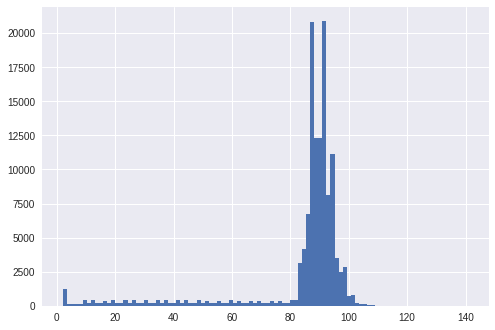

In [0]:
import matplotlib.pyplot as plt

lengths = [len(p['text']) for p in wiki_dataset]
print(max(lengths))
plt.hist(lengths, bins=100)

Our model is going to be made by multiple LSTM layers stacked on top of each other.


In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class CharLstmLanguageModel(nn.Module):
    def __init__(self, char_embedding_dim, lstm_dim, projection_size, n_lstm_layers=1, dropout=0):
        super().__init__()
        self.n_lstm_layers = n_lstm_layers
        self.n_chars = 259
        self.char_embedding_dim = char_embedding_dim
        self.projection_size = projection_size
        
        # initialize lookup table of fixed dictionary and size, 0 = padding idx
        self.char_embedder = nn.Embedding(self.n_chars, 
                                          self.char_embedding_dim, 
                                          padding_idx=258
        )
        
        # lstm_dim = size of one lstm hidden layer
        # n_lstm_layers = number of stacked lstms
        
        self.lstm = nn.LSTM(char_embedding_dim, 
                            lstm_dim, 
                            n_lstm_layers, 
                            batch_first=True, 
                            dropout=dropout, 
                            bidirectional=False,  # We want to use this for generation so we won't have all the seq together
        )
        
        # creates a pipeline to transform the output of the lstm into a list where each position is a char idx
        # and its values can be projected by ReLU to be the confidence for each character
        self.projection = nn.Sequential(*[
            nn.Linear(lstm_dim, self.projection_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.projection_size, self.n_chars),
        ])
        
    def forward(self, char_ids, hidden=None, pack=True):
        # char_ids of shape [b_sz, max_sq_len (w/ pads)]
        x = self.char_embedder(char_ids)  # -> shape [b_sz, max_sq_len, char_emb_sz]
        
        x, hidden = self.lstm(x, hidden)  # -> shape [b_sz, max_sq_len, lstm_dim]

        return self.projection(x), hidden  # -> projection's shape: [b_sz, max_sq_len, total_num_characters]
                                           # -> (seq_len, batch, num_directions * hidden_size)
                                           # hidden is a tuple (hidden_state, cell_state). Both are of shape (n_lstm_layers, b_sz, lstm_dim) 
        

In [0]:
from torch.nn.utils.rnn import pad_sequence, pack_sequence

def padded_collate(batch, padding_idx=258):
    x = pad_sequence([elem['text'] for elem in batch], batch_first=True, padding_value=padding_idx)
    y = pad_sequence([elem['next'] for elem in batch], batch_first=True, padding_value=padding_idx)
    
    return {'text': x, 'next': y}

In [0]:
model = CharLstmLanguageModel(16,  # char_embedding_dim 
                              1024,  # lstm_hidden_dim
                              512,
                              n_lstm_layers=2,
                              dropout=0.3,
                             )

In case you want to load an already trained model and fine tuning it

In [0]:
model

CharLstmLanguageModel(
  (char_embedder): Embedding(259, 16, padding_idx=258)
  (lstm): LSTM(16, 1024, num_layers=2, batch_first=True, dropout=0.3)
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
    (3): Linear(in_features=512, out_features=259, bias=True)
  )
)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Let's define a train function.

In [0]:
def train(model, dataset, n_epochs, lr=0.01, batch_size=32, model_checkpoint_folder=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='elementwise_mean')
    
    train_sampler = BucketBatchSampler(dataset, batch_size, True, sort_key=lambda r: len(r['text']))
    data_loader = DataLoader(dataset, batch_sampler=train_sampler, collate_fn=padded_collate, num_workers=mp.cpu_count())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
    
    model = model.to(device).train()
    
    avg_loss = 0.0
    avg_mom=0.98
    losses = []
    for epoch in range(1, n_epochs+1):
        t = tqdm(iter(data_loader), leave=False, total=len(data_loader), miniters=0)
        epoch_losses = []
        for i, batch in enumerate(t):
            optimizer.zero_grad()

            label = batch['next'].to(device)
            pred, _ = model(batch['text'].to(device))
            
            batch_sz, seq_len, n_chars = pred.shape
            
            loss = criterion(pred.view(batch_sz * seq_len, -1), label.view(batch_sz * seq_len))
            
            loss_numeric = float(loss)
            epoch_losses.append(loss_numeric)
            avg_loss = avg_loss * avg_mom + loss_numeric * (1-avg_mom)
            debias_loss = avg_loss / (1 - avg_mom**(i+1))
            
            lrs = ",".join([str(param_group['lr']) for param_group in optimizer.param_groups])
            t.set_postfix(loss=debias_loss, 
                          learning_rate=lrs,
                          epoch=epoch,
                         )

            loss.backward()
            # update weights using optimizer formula
            optimizer.step()
        
        epoch_loss = sum(epoch_losses) / len(data_loader)
        print(f"\nEpoch {epoch} loss: {epoch_loss}")
        losses.append(epoch_loss)
        plateau_scheduler.step(epoch_loss)
        epoch_losses = []
        # save model
        if model_checkpoint_folder:
            model_save_path = model_checkpoint_folder + "model_epoch_{}.pt".format(epoch)
            torch.save(model, model_save_path)
    return losses
    
        

In [0]:
MODEL_CHECKPOINT_FOLDER = "checkpoints/"
if not os.path.isdir(MODEL_CHECKPOINT_FOLDER):
  os.makedirs(MODEL_CHECKPOINT_FOLDER)

In [0]:
model

In [0]:
!nvidia-smi

In [0]:
losses = train(model, 
               wiki_dataset, 
               10, 
               lr=0.003, 
               batch_size=128, 
               model_checkpoint_folder=MODEL_CHECKPOINT_FOLDER
              )

  0%|          | 0/995 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


                                                                                         
Epoch 1 loss: 1.401535777051245


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CharLstmLanguageModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


                                                                                         
Epoch 2 loss: 1.3980323322454289
                                                                                          
Epoch 3 loss: 1.3928589433281866
                                                                                          
Epoch 4 loss: 1.387839260352916
                                                                                          
Epoch 5 loss: 1.3836720950040386
                                                                                          
Epoch 6 loss: 1.3807512765553729
                                                                                          
Epoch 7 loss: 1.3764163515076566
                                                                                          
Epoch 8 loss: 1.3733537849469402
                                                                                          
Epoch 9 loss: 1.370907208428311
           

In [0]:
from google.colab import files
model_save_path = MODEL_CHECKPOINT_FOLDER + "wiki_model_30epochs_checkpoint.pt"
torch.save(model, model_save_path)
files.download(model_save_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CharLstmLanguageModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
print(losses)

[1.401535777051245, 1.3980323322454289, 1.3928589433281866, 1.387839260352916, 1.3836720950040386, 1.3807512765553729, 1.3764163515076566, 1.3733537849469402, 1.370907208428311, 1.3657020920485108]


In [0]:
losses = [2.587973585919519, 1.8878660248751615, 1.7248724930250465, 1.647950033326844, 1.6195444668357695, 1.553175619439264, 1.5359190926479933, 1.5239209031938907, 1.5110083296670387, 1.4999794643128936, 1.4919527612139831, 1.4708082113433723, 1.4594857539962884, 1.4469362130117176, 1.4397834873678697, 1.4322743370005833, 1.423765480458437, 1.4182304330806637, 1.4115374595675636, 1.406341798041933, 1.401535777051245, 1.401535777051245, 1.3980323322454289, 1.3928589433281866, 1.387839260352916 , 1.3836720950040386 , 1.3807512765553729 , 1.3764163515076566 , 1.3733537849469402 , 1.370907208428311, 1.3657020920485108]

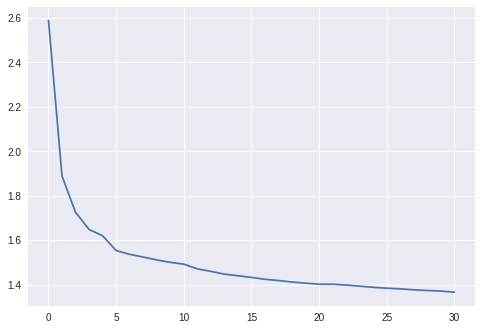

In [0]:
plt.plot(losses)

# Sampling from the model


The model may not have learned how to form valid utf-8 sequences (eg for emojis) so we offer an optional argument that sets all non-ASCII bytes to 0 probability.

In [0]:
def sample(model, start_token='', max_iters=100, temperature=1.0, no_unicode=False):
  model = model.to('cpu')
  enc = CharByteEncoder()
  input_seq = enc.encode(start_token).tolist()[:-1] # Drop the end token
  
  hidden_prev = None
 
  for t in range(max_iters):
    x_t = torch.LongTensor([input_seq[t]]).unsqueeze(0)  # (b_sz=1, seq_len=1)
    y_t, hidden_t = model(x_t, hidden_prev)
    probs_t = F.softmax(y_t.squeeze() / temperature, dim=0)
    
    if no_unicode:
      mask = torch.cat([torch.ones(128), torch.zeros(128), torch.ones(3)])
      probs_t = probs_t * mask

    x_next = torch.multinomial(probs_t, 1)  # Randomly picks, based on probabilities

    input_seq.append(int(x_next))
    if int(x_next) == enc.end_idx:
      return enc.decode(torch.LongTensor(input_seq))
    hidden_prev = hidden_t
    
  return enc.decode(torch.LongTensor(input_seq + [enc.end_idx]))
  

In [0]:
sample(model, no_unicode=False)

'<s>smaller claim in the gun .</s>'

# Retraining on DadJokes

Let's see if pretraining on Wikipedia helped.

In [0]:
DADJOKES_DATASET_PATH = "shortjokes.csv"
DADJOKES_DATASET_FILE_ID = "1bplfuUrJEnpi6r78LQtO3IufzCSSVJaC"
DADJOKES_DATASET_URL = "https://github.com/amoudgl/short-jokes-dataset/raw/master/shortjokes.csv"

In [0]:
import urllib.request
...
# Download the file from `url` and save it locally under `file_name`:
urllib.request.urlretrieve(DADJOKES_DATASET_URL, DADJOKES_DATASET_PATH)

('shortjokes.csv', <http.client.HTTPMessage at 0x7f71e0296cf8>)

In [0]:
from torch.utils.data import Dataset

class DadJokesDataset(Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path, sep=',')['Joke'].tolist()
        self.text_encoder = CharByteEncoder()
        self.samples = []
        for _ in range(len(self.data)):
            joke = self.data.pop()
            encoded_joke = self.text_encoder.encode(joke)
            encoded_sample = self.generate_language_model_samples(encoded_joke)
            self.samples.append(encoded_sample)
        del self.data        
        
    def generate_language_model_samples(self, joke):
        """
        Input: '<s>my funny joke</s>'
        Output: {
          text: '<s>my funny joke'
          next: 'my funny joke</s>'
        }
        """
        res = {}
        res['text'] = joke[:-1]
        res['next'] = joke[1:]
        return res
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def getitem_readable(self, i):
        return {'text': self.text_encoder.decode(self.samples[i]['text']),
               'next': self.text_encoder.decode(self.samples[i]['next'])}
    

In [0]:
jokes_dataset = DadJokesDataset(DADJOKES_DATASET_PATH)

Checking that the max size of a sequence is not too bad to make sure padding and memory are taken care of

201


(array([  65.,   76.,  125.,  109.,  113.,  142.,  211.,  272.,  327.,
         205.,  502.,  656.,  825., 1032., 1272., 1597., 2009., 2478.,
        2880., 1597., 3411., 3790., 4162., 4623., 4715., 4784., 5104.,
        5312., 5349., 2627., 5341., 5466., 5458., 5416., 5303., 5320.,
        5157., 5186., 5027., 2452., 4730., 4599., 4662., 4359., 4202.,
        4099., 3972., 3823., 3781., 1800., 3568., 3481., 3337., 3260.,
        3163., 3011., 2966., 2911., 2899., 1452., 2742., 2696., 2784.,
        2789., 2938., 3697., 4748., 6453., 5351.,  567.,  961.,  932.,
         845.,  837.,  778.,  763.,  721.,  664.,  643.,  275.,  600.,
         592.,  578.,  522.,  496.,  508.,  523.,  511.,  492.,  225.,
         445.,  398.,  412.,  401.,  389.,  401.,  368.,  370.,  346.,
         325.]),
 array([ 11. ,  12.9,  14.8,  16.7,  18.6,  20.5,  22.4,  24.3,  26.2,
         28.1,  30. ,  31.9,  33.8,  35.7,  37.6,  39.5,  41.4,  43.3,
         45.2,  47.1,  49. ,  50.9,  52.8,  54.7,  56.6,  58

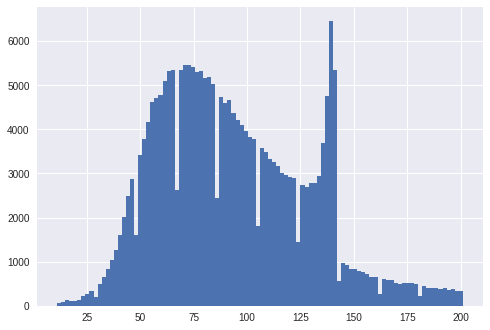

In [0]:
import matplotlib.pyplot as plt

lengths = [len(p['text']) for p in jokes_dataset]
print(max(lengths))
plt.hist(lengths, bins=100)

In [0]:
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

Mon Mar  4 17:45:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    24W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dadjokes_from_wiki_model_10_epochs_checkpoint.pt to dadjokes_from_wiki_model_10_epochs_checkpoint (1).pt
User uploaded file "dadjokes_from_wiki_model_10_epochs_checkpoint.pt" with length 53330801 bytes


In [0]:
model = torch.load(fn)

In [0]:
losses = train(model, 
               jokes_dataset, 
               10, 
               lr=0.01, 
               batch_size=128, 
               model_checkpoint_folder=MODEL_CHECKPOINT_FOLDER
              )

  0%|          | 0/1809 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


                                                                                        
Epoch 1 loss: 2.0536029713795685


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CharLstmLanguageModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


                                                                                           
Epoch 2 loss: 2.0050528563472563
                                                                                           
Epoch 3 loss: 1.9661188741096678
                                                                                           
Epoch 4 loss: 1.9397527801193144
                                                                                           
Epoch 5 loss: 1.934325941364168
                                                                                           
Epoch 6 loss: 1.9362773379283165
                                                                                           
Epoch 7 loss: 1.9262171407771282
                                                                                           
Epoch 8 loss: 1.9572868219326056
                                                                                           
Epoch 9 loss: 1.9326756192281669
 

In [0]:
from google.colab import files
model_save_path = MODEL_CHECKPOINT_FOLDER + "dadjokes_from_wiki_model_20_epochs_checkpoint.pt"
torch.save(model, model_save_path)
files.download(model_save_path)

In [0]:
losses = train(model, 
               jokes_dataset, 
               10, 
               lr=0.001, 
               batch_size=128, 
               model_checkpoint_folder=MODEL_CHECKPOINT_FOLDER
              )

In [0]:
from google.colab import files
model_save_path = MODEL_CHECKPOINT_FOLDER + "dadjokes_from_wiki_model_30_epochs_checkpoint.pt"
torch.save(model, model_save_path)
files.download(model_save_path)

Now we should be able to sample jokes.

In [0]:
sample(model, no_unicode=False)

'<s>Aow deeper. Thif to buttcaus the said and MS betwe wellsdis mo Jis.</s>'

In [0]:
sample(model, no_unicode=True)

'<s>What eirilet a Hanging the bele beer peraligugant... Stemmind to mosriended Comete. I courn Jirdramm</s>'

# Next steps


*   Use larger Wiki dataset (not fitting in RAM)
*   Increase Dad Jokes dataset (scrape)
*   Train Dad Jokes model more
*   Use word encoder
*   Use ASCII only
*   Train on lowercase 
*   Remove jokes too short
*   Add validation



